## Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pylab as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss

In [2]:
pd.set_option('display.max_rows', 25000)
torch.set_printoptions(threshold=100_000)

## Preprocessing Data

In [3]:
path = './gludata/data'
with open(path+"/train_data_pyforecast.pkl", 'rb') as f:
      train_data_raw = pickle.load(f)
with open(path+"/val_data_pyforecast.pkl", 'rb') as f:
      val_data_raw = pickle.load(f)
with open(path+"/test_data_pyforecast.pkl", 'rb') as f:
      test_data_raw = pickle.load(f)

In [4]:
# subset = [0, 1, 2, 3]
# val_data_raw = [x for x in val_data_raw if x[0] in subset]
# train_data_raw = [x for x in train_data_raw if x[0] in subset]

In [5]:
def read_data(data, id_start):
    data_len = sum([len(data[i][1]) for i in range(len(data))])
    data_pd = pd.DataFrame(index = range(data_len),
                           columns = ["timeidx", "id", "subject", "CGM", 
                                      "dayofyear", "dayofmonth", "dayofweek", "hour", 
                                      "minute", "date"])
    start = 0
    for i in range(len(data)):
        block_len = len(data[i][1]) 
        data_pd["timeidx"][start:(start+block_len)] = range(block_len)
        data_pd["id"][start:(start+block_len)] = [id_start + i] * block_len
        data_pd["subject"][start:(start+block_len)] = [data[i][0]] * block_len
        data_pd["CGM"][start:(start+block_len)] = data[i][1].flatten() 
        data_pd["date"][start:(start+block_len)] = data[i][3]
        start += block_len
    
    # set format
    data_pd["id"] = data_pd["id"].astype(str).astype("string").astype("category")
    data_pd["subject"] = data_pd["subject"].astype(str).astype("string").astype("category")
    data_pd["CGM"] = data_pd["CGM"].astype("float")
    data_pd["timeidx"] = data_pd["timeidx"].astype("int")
    
    #extract time features
    data_pd["date"] = pd.to_datetime(data_pd["date"])
    data_pd["dayofyear"] = data_pd["date"].dt.dayofyear.astype("string").astype("category")
    data_pd["dayofmonth"] = data_pd["date"].dt.day.astype("string").astype("category")
    data_pd["dayofweek"] = data_pd["date"].dt.dayofweek.astype("string").astype("category")
    data_pd["hour"] = data_pd["date"].dt.hour.astype("string").astype("category")
    data_pd["minute"] = data_pd["date"].dt.minute.astype("string").astype("category")
    
    # reset index
    data_pd = data_pd.reset_index()
    data_pd = data_pd.drop(columns=["index"])
    return data_pd

train_data_pd = read_data(train_data_raw, 0)
val_data_pd = read_data(val_data_raw, len(train_data_raw))
test_data_pd = read_data(test_data_raw, len(train_data_raw)+len(val_data_raw))

In [6]:
train_data_pd

,timeidx,id,subject,CGM,dayofyear,dayofmonth,dayofweek,hour,minute,date
0,0,0,0,-2.664835,274,1,4,17,17,2010-10-01 17:17:00
1,1,0,0,-2.637363,274,1,4,17,22,2010-10-01 17:22:00
2,2,0,0,-2.692308,274,1,4,17,27,2010-10-01 17:27:00
3,3,0,0,-2.747253,274,1,4,17,32,2010-10-01 17:32:00
4,4,0,0,-3.214286,274,1,4,17,37,2010-10-01 17:37:00
...,...,...,...,...,...,...,...,...,...,...
364471,215,488,37,-0.879121,79,20,2,13,18,2013-03-20 13:18:00
364472,216,488,37,-0.769231,79,20,2,13,23,2013-03-20 13:23:00
364473,217,488,37,-0.824176,79,20,2,13,28,2013-03-20 13:28:00
364474,218,488,37,-0.741758,79,20,2,13,33,2013-03-20 13:33:00


In [7]:
val_data_pd

,timeidx,id,subject,CGM,dayofyear,dayofmonth,dayofweek,hour,minute,date
0,0,489,0,-2.637363,258,15,6,14,7,2013-09-15 14:07:00
1,1,489,0,-2.637363,258,15,6,14,12,2013-09-15 14:12:00
2,2,489,0,-2.692308,258,15,6,14,17,2013-09-15 14:17:00
3,3,489,0,-2.829670,258,15,6,14,22,2013-09-15 14:22:00
4,4,489,0,-2.994505,258,15,6,14,27,2013-09-15 14:27:00
...,...,...,...,...,...,...,...,...,...,...
25547,462,547,37,-1.703297,80,21,3,11,33,2013-03-21 11:33:00
25548,463,547,37,-1.785714,80,21,3,11,38,2013-03-21 11:38:00
25549,464,547,37,-1.620879,80,21,3,11,43,2013-03-21 11:43:00
25550,465,547,37,-1.318681,80,21,3,11,48,2013-03-21 11:48:00


In [8]:
train_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364476 entries, 0 to 364475
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   timeidx     364476 non-null  int64         
 1   id          364476 non-null  category      
 2   subject     364476 non-null  category      
 3   CGM         364476 non-null  float64       
 4   dayofyear   364476 non-null  category      
 5   dayofmonth  364476 non-null  category      
 6   dayofweek   364476 non-null  category      
 7   hour        364476 non-null  category      
 8   minute      364476 non-null  category      
 9   date        364476 non-null  datetime64[ns]
dtypes: category(7), datetime64[ns](1), float64(1), int64(1)
memory usage: 11.2 MB


In [9]:
train_data = TimeSeriesDataSet(
    train_data_pd,
    time_idx="timeidx",
    target="CGM",
    group_ids=["id"],
    max_encoder_length=180,
    max_prediction_length=12,
    static_categoricals=["subject"],
    time_varying_known_categoricals= ["dayofyear", 
                                      "dayofmonth", 
                                      "dayofweek", 
                                      "hour",
                                      "minute"],
    time_varying_known_reals=["timeidx"],
    time_varying_unknown_reals = ["CGM"],
    scalers=[],
    add_relative_time_idx=True,
    add_encoder_length=True,
)
train_dataloader = train_data.to_dataloader(train=True, batch_size=64, num_workers=24)


val_data = TimeSeriesDataSet(
    val_data_pd,
    time_idx="timeidx",
    target="CGM",
    group_ids=["id"],
    max_encoder_length=180,
    max_prediction_length=12,
    static_categoricals=["subject"],
    time_varying_known_categoricals= ["dayofyear", 
                                      "dayofmonth", 
                                      "dayofweek", 
                                      "hour",
                                      "minute"],
    time_varying_known_reals=["timeidx"],
    time_varying_unknown_reals = ["CGM"],
    scalers=[],
    add_relative_time_idx=True,
    add_encoder_length=True,
)
val_dataloader = val_data.to_dataloader(train=False, batch_size=64, num_workers=24)

test_data = TimeSeriesDataSet(
    test_data_pd,
    time_idx="timeidx",
    target="CGM",
    group_ids=["id"],
    max_encoder_length=180,
    max_prediction_length=12,
    static_categoricals=["subject"],
    time_varying_known_categoricals= ["dayofyear", 
                                      "dayofmonth", 
                                      "dayofweek", 
                                      "hour",
                                      "minute"],
    time_varying_known_reals=["timeidx"],
    time_varying_unknown_reals = ["CGM"],
    scalers=[],
    add_relative_time_idx=True,
    add_encoder_length=True,
)
test_dataloader = test_data.to_dataloader(train=False, batch_size=64, num_workers=24)

## Training the model

In [10]:
# configure network and trainer
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath='./saved_models',
    filename="tft-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=1000,
    progress_bar_refresh_rate=10,
    log_every_n_steps=1,
    gpus=1,
    weights_summary="top",
    callbacks=[early_stop_callback, checkpoint_callback],
)


tft = TemporalFusionTransformer.from_dataset(
    train_data,
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    output_size=7, 
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/home/mrsergazinov/anaconda3/envs/pytorch-forecast/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 1314.2k


In [11]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2.9 K 
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 4.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 16.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.9 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial_cell_lstm 

Validation sanity check:   0%|                                                                                                         | 0/2 [00:00<?, ?it/s]

/home/mrsergazinov/anaconda3/envs/pytorch-forecast/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0:  95%|███████████████████████████████████████████████████████████▉   | 4240/4459 [11:33<00:35,  6.11it/s, loss=0.158, v_num=3, train_loss_step=0.130]
Validating: 0it [00:00, ?it/s]
Validating:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████  | 220/224 [00:16<00:00, 14.59it/s]

/home/mrsergazinov/anaconda3/envs/pytorch-forecast/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(



Epoch 1:  95%|█████████████████████▊ | 4240/4459 [11:35<00:35,  6.10it/s, loss=0.156, v_num=3, train_loss_step=0.147, val_loss=0.159, train_loss_epoch=0.173]
Validating: 0it [00:00, ?it/s]
Epoch 2:  95%|█████████████████████▊ | 4240/4459 [11:49<00:36,  5.97it/s, loss=0.149, v_num=3, train_loss_step=0.183, val_loss=0.153, train_loss_epoch=0.157]
Validating: 0it [00:00, ?it/s]
Epoch 3:  95%|█████████████████████▊ | 4240/4459 [11:57<00:37,  5.91it/s, loss=0.154, v_num=3, train_loss_step=0.134, val_loss=0.151, train_loss_epoch=0.154]
Validating: 0it [00:00, ?it/s]
Epoch 4:  95%|█████████████████████▊ | 4240/4459 [12:01<00:37,  5.87it/s, loss=0.149, v_num=3, train_loss_step=0.166, val_loss=0.152, train_loss_epoch=0.151]
Validating: 0it [00:00, ?it/s]
Validating:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████  | 220/224 [00:18<00:00, 13.58it/s]


Epoch 5:  95%|█████████████████████▊ | 4240/4459 [12:11<00:37,  5.80it/s, loss=0.144, v_num=3, train_loss_step=0.169, val_loss=0.153, train_loss_epoch=0.148]
Validating: 0it [00:00, ?it/s]
Epoch 6:  95%|█████████████████████▊ | 4240/4459 [12:15<00:38,  5.76it/s, loss=0.134, v_num=3, train_loss_step=0.137, val_loss=0.154, train_loss_epoch=0.145]
Validating: 0it [00:00, ?it/s]
Epoch 7:  95%|█████████████████████▊ | 4240/4459 [12:10<00:37,  5.80it/s, loss=0.137, v_num=3, train_loss_step=0.117, val_loss=0.159, train_loss_epoch=0.141]
Validating: 0it [00:00, ?it/s]
Epoch 8:  95%|█████████████████████▊ | 4240/4459 [12:26<00:38,  5.68it/s, loss=0.123, v_num=3, train_loss_step=0.120, val_loss=0.165, train_loss_epoch=0.138]
Validating: 0it [00:00, ?it/s]
Validating:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████  | 220/224 [00:20<00:00, 12.84it/s]


Epoch 9:  95%|█████████████████████▊ | 4240/4459 [12:25<00:38,  5.69it/s, loss=0.117, v_num=3, train_loss_step=0.119, val_loss=0.173, train_loss_epoch=0.124]
Validating: 0it [00:00, ?it/s]
Epoch 10:  95%|████████████████████▉ | 4240/4459 [30:16<01:33,  2.33it/s, loss=0.119, v_num=3, train_loss_step=0.105, val_loss=0.181, train_loss_epoch=0.118]
Validating: 0it [00:00, ?it/s]
Epoch 11:  95%|████████████████████▉ | 4240/4459 [12:23<00:38,  5.70it/s, loss=0.107, v_num=3, train_loss_step=0.116, val_loss=0.187, train_loss_epoch=0.113]
Validating: 0it [00:00, ?it/s]
Epoch 12:  95%|████████████████████▉ | 4240/4459 [13:10<00:40,  5.36it/s, loss=0.102, v_num=3, train_loss_step=0.103, val_loss=0.194, train_loss_epoch=0.109]
Validating: 0it [00:00, ?it/s]
Validating:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████  | 220/224 [00:22<00:00, 12.25it/s]


Epoch 12: 100%|██████████████████████| 4459/4459 [13:35<00:00,  5.46it/s, loss=0.103, v_num=3, train_loss_step=0.104, val_loss=0.201, train_loss_epoch=0.105]


## Evaluate

In [35]:
# best_model_path = trainer.checkpoint_callback.best_model_path
saved_model_path = './saved_models/tft.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(saved_model_path)

In [53]:
pred, x = best_tft.predict(test_dataloader, mode='raw', return_x=True)

In [37]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])

In [54]:
UPPER = 402
LOWER = 38
SCALE_1 = 5
SCALE_2 = 2
BATCH_SIZE=1

pred = (pred['prediction'] + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
pred_median = pred[:, :, 3] 
actuals = (actuals + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER

In [39]:
# evaluate on full data set
def ape_rmse(actuals, predictions, length, event):
    HYPO_THR = 70
    HYPER_THR = 180

    if event == 'HYPO':
        select = (actuals <= HYPO_THR).any(axis=1)
    elif event == 'HYPER':
        select = (actuals <= HYPER_THR).any(axis=1)
    elif event == 'EVENT':
        select = ((actuals <= HYPO_THR).any(axis=1) |  (actuals >= HYPER_THR).any(axis=1))
    else:
        select = range(actuals.shape[0])
    actuals = actuals[select, :]
    predictions = predictions[select, :]
    ape = ((actuals[:, :length] - predictions[:, :length]).abs() / actuals[:, :length].abs()).mean(axis=1).median()
    rmse = ((actuals[:, :length] - predictions[:, :length]) ** 2).mean(axis=1).sqrt().median()
    return (ape, rmse)

lengths = [3, 6, 9 , 12]
events = ['HYPO', 'HYPER', 'EVENT', 'FULL']

for length in lengths:
    for event in events:
        print('Length: {0}, event: {1}, ape: {2}, rmse: {3}'.format(length, 
                                                                    event, 
                                                                    *ape_rmse(actuals, pred_median, length, event)))

Length: 3, event: HYPO, ape: 0.05293843150138855, rmse: 3.8685712814331055
Length: 3, event: HYPER, ape: 0.0360928513109684, rmse: 4.909085750579834
Length: 3, event: EVENT, ape: 0.030851567164063454, rmse: 6.680118560791016
Length: 3, event: FULL, ape: 0.03132656589150429, rmse: 5.665421009063721
Length: 6, event: HYPO, ape: 0.09221368283033371, rmse: 6.828280925750732
Length: 6, event: HYPER, ape: 0.05934754014015198, rmse: 8.380556106567383
Length: 6, event: EVENT, ape: 0.04713955894112587, rmse: 10.56157112121582
Length: 6, event: FULL, ape: 0.04902273043990135, rmse: 9.146695137023926
Length: 9, event: HYPO, ape: 0.12937702238559723, rmse: 9.781110763549805
Length: 9, event: HYPER, ape: 0.08046332001686096, rmse: 11.445329666137695
Length: 9, event: EVENT, ape: 0.06269853562116623, rmse: 14.202861785888672
Length: 9, event: FULL, ape: 0.06514804065227509, rmse: 12.354683876037598
Length: 12, event: HYPO, ape: 0.16704291105270386, rmse: 12.859658241271973
Length: 12, event: HYPER, 

In [55]:
pred_one = np.vstack((pred[0, :, 0].numpy(),
          pred[0, :, 3].numpy(),
          pred[0, :, 6].numpy(),))

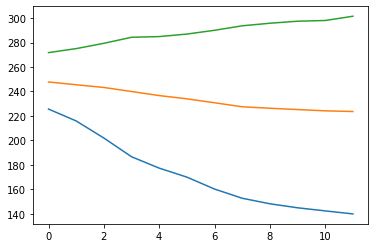

In [56]:
plt.plot(np.transpose(pred_one))